# Out-of-sample forecasting experiments

I conduct out-of-sample forecasting experiments to understand what kind of text data (topics, sentiment, or uncertainty) helps improve forecasts of three quarterly variables (GDP, Investment, and Consumption) more.

In this notebook, I evaluate the performance of dynamic factor models (DFM) using hard data, survey information, and 10 uncertainty-adjusted topics most highly correlated with Consumption growth (out of 200 topics estimated on articles published before 2008 using all sources). I forecast Consumption growth and integrate text data into economic forecasting.

## Experiment Details

- **Data Sources:** Hard data, surveys, 10 uncertainty-adjusted topics (<=2007, 200 topics, all sources).
- **Forecast Target:** Consumption growth.
- **Model:** Dynamic Factor Models (DFM).
- **Parameters Explored:**
  - **Number of Hard+Surveys Factors:** 1 to 2
  - **Number of Text Factors:** 1
  - **Factor Order:** 1 to 3

In [1]:
import os
import time
import datetime
import pandas as pd
import DFM_function

# Define inputs common to all models
q_var = 'Consumption'                     # quarterly variable being forecasted
additional_factors = 'HardSurveys+Text'   # switch to separate factors scenario
start = '1991-04'
text_type = "topics_uncertainty"
estimation_period = "2007"
num_topics = "200"
source = "all"
with_text = True

# Generate list of forecast_month strings for quarters from 2008Q1 to 2018Q4
# forecast_month is set to the month corresponding to quarter-end:
# Q1: 'YYYY-03', Q2: 'YYYY-06', Q3: 'YYYY-09', Q4: 'YYYY-12'
forecast_months = []
for year in range(2008, 2019):
    forecast_months.extend([f"{year}-03", f"{year}-06", f"{year}-09", f"{year}-12"])
    
# Define the vintage column names 
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Create directories to save forecasts and MSE results
os.makedirs(f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}", exist_ok=True)
os.makedirs(f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}", exist_ok=True)

# Load the actual growth data
actual_growth_file = f"../{q_var}_growth_actual.csv"
actual_growth = pd.read_csv(actual_growth_file)

# Record overall start time
overall_start = time.time()

# Loop over the number of HardSurveys factors (1 or 2) and factor order values from 1 to 3
for num_factors in range(1, 3):  # 1 or 2 HardSurveys factors
    for order in range(1, 4):    # Varying factor order: 1, 2, 3
        
        # Define model-specific parameters
        factor_multiplicities = {'HardSurveys': num_factors, 'Text': 1}
        factor_orders = {'HardSurveys': order, 'Text': order}

        # Prepare lists to store each quarter's forecasts and row labels
        forecasts_all_quarters = []
        row_labels = []
        
        # Start timing for this model
        start_time = time.time()

        # Loop over each forecast month, get the forecasts, and store the results
        for fm in forecast_months:
            # Use the forecast_month string as the row label
            row_labels.append(fm)

            # Run the forecast function for this quarter
            forecasts_dict = DFM_function.get_forecasts(
                forecast_month = fm,
                q_var = q_var,
                additional_factors = additional_factors,
                factor_multiplicities = factor_multiplicities,
                factor_orders = factor_orders,
                start = start,
                text_type = text_type,
                estimation_period = estimation_period,
                num_topics = num_topics,
                source = source,
                with_text = with_text
            )

            # Obtain the correct ordering of vintages
            vintages_order = DFM_function.vintage_dates(fm)
            # Extract the forecast value for each vintage in that order
            quarter_forecasts = [forecasts_dict[vint] for vint in vintages_order]
            forecasts_all_quarters.append(quarter_forecasts)

        # Create a DataFrame with rows labeled by the forecast_month strings and columns as vintage names
        results = pd.DataFrame(forecasts_all_quarters, index=row_labels, columns=vintage_col_names)
        
        # Stop timing for this model and print elapsed time
        elapsed = time.time() - start_time
        elapsed_time = datetime.timedelta(seconds=elapsed)
        print(f"Model with HardSurveys factors = {num_factors} and order = {order} estimated in {elapsed_time}.")

        # Construct the output file name
        factors_str = f"HS_{num_factors}_{order}"
        file_name = f"forecasts_{q_var}_{factors_str}.csv"

        # Save the CSV file in a subfolder 
        output_path = os.path.join(f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}", file_name)
        results.to_csv(output_path, index=True)
        
        # ----- MSE Calculation -----
        # Load forecasts
        forecasts = pd.read_csv(output_path, index_col=0)
        # Make sure the index is a column named "date"
        forecasts.index.name = "date"
        forecasts.reset_index(inplace=True)

        # Merge dfs by date 
        merged = pd.merge(forecasts, actual_growth, on="date", how="inner")

        # Calculate the Mean Squared Error (MSE) for each vintage column
        mse_dict = {}
        for col in vintage_col_names:
            mse = ((merged[col] - merged["growth"]) ** 2).mean()
            mse_dict[col] = mse

        # Create a df with one row (the MSE values for each forecasting horizon)
        mse_df = pd.DataFrame(mse_dict, index=[0])

        # Save MSE results to CSV
        mse_file_name = f"MSE_{q_var}_{factors_str}.csv"
        mse_output_path = os.path.join(f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}", mse_file_name)
        mse_df.to_csv(mse_output_path, index=False)
        
# Stop overall timing and print overall elapsed time
overall_elapsed = time.time() - overall_start
overall_elapsed_time = datetime.timedelta(seconds=overall_elapsed)
print(f"Overall time taken for running all models: {overall_elapsed_time}.")

EM start iterations, llf=-11983
EM converged at iteration 58, llf=-11735, convergence criterion=9.8896e-07 < tolerance=1e-06
EM start iterations, llf=-11996
EM converged at iteration 58, llf=-11747, convergence criterion=9.8802e-07 < tolerance=1e-06
EM start iterations, llf=-12049
EM converged at iteration 58, llf=-11798, convergence criterion=9.6774e-07 < tolerance=1e-06
EM start iterations, llf=-12056
EM converged at iteration 58, llf=-11805, convergence criterion=9.6763e-07 < tolerance=1e-06
EM start iterations, llf=-12120
EM converged at iteration 59, llf=-11864, convergence criterion=9.6807e-07 < tolerance=1e-06
EM start iterations, llf=-12129
EM converged at iteration 58, llf=-11871, convergence criterion=9.9731e-07 < tolerance=1e-06
EM start iterations, llf=-12184
EM converged at iteration 58, llf=-11927, convergence criterion=9.8545e-07 < tolerance=1e-06
EM start iterations, llf=-12184
EM converged at iteration 58, llf=-11927, convergence criterion=9.8545e-07 < tolerance=1e-06


EM start iterations, llf=-13763
EM converged at iteration 45, llf=-13561, convergence criterion=9.8628e-07 < tolerance=1e-06
EM start iterations, llf=-13824
EM converged at iteration 44, llf=-13633, convergence criterion=9.9714e-07 < tolerance=1e-06
EM start iterations, llf=-13830
EM converged at iteration 44, llf=-13636, convergence criterion=9.9976e-07 < tolerance=1e-06
EM start iterations, llf=-13884
EM converged at iteration 44, llf=-13685, convergence criterion=9.9682e-07 < tolerance=1e-06
EM start iterations, llf=-13884
EM converged at iteration 44, llf=-13685, convergence criterion=9.9682e-07 < tolerance=1e-06
EM start iterations, llf=-13895
EM converged at iteration 45, llf=-13698, convergence criterion=9.6389e-07 < tolerance=1e-06
EM start iterations, llf=-13947
EM converged at iteration 45, llf=-13751, convergence criterion=9.5674e-07 < tolerance=1e-06
EM start iterations, llf=-13952
EM converged at iteration 45, llf=-13755, convergence criterion=9.5726e-07 < tolerance=1e-06


EM start iterations, llf=-15531
EM converged at iteration 46, llf=-15318, convergence criterion=9.9715e-07 < tolerance=1e-06
EM start iterations, llf=-15531
EM converged at iteration 46, llf=-15318, convergence criterion=9.9715e-07 < tolerance=1e-06
EM start iterations, llf=-15541
EM converged at iteration 46, llf=-15327, convergence criterion=9.9635e-07 < tolerance=1e-06
EM start iterations, llf=-15595
EM converged at iteration 46, llf=-15382, convergence criterion=9.9829e-07 < tolerance=1e-06
EM start iterations, llf=-15606
EM converged at iteration 46, llf=-15393, convergence criterion=9.9509e-07 < tolerance=1e-06
EM start iterations, llf=-15657
EM converged at iteration 47, llf=-15443, convergence criterion=9.5787e-07 < tolerance=1e-06
EM start iterations, llf=-15665
EM converged at iteration 46, llf=-15450, convergence criterion=9.9809e-07 < tolerance=1e-06
EM start iterations, llf=-15712
EM converged at iteration 46, llf=-15496, convergence criterion=9.9239e-07 < tolerance=1e-06


EM start iterations, llf=-17263
EM converged at iteration 53, llf=-17017, convergence criterion=9.9704e-07 < tolerance=1e-06
EM start iterations, llf=-17268
EM converged at iteration 53, llf=-17022, convergence criterion=9.971e-07 < tolerance=1e-06
EM start iterations, llf=-17324
EM converged at iteration 54, llf=-17077, convergence criterion=9.7019e-07 < tolerance=1e-06
EM start iterations, llf=-17330
EM converged at iteration 54, llf=-17083, convergence criterion=9.7053e-07 < tolerance=1e-06
EM start iterations, llf=-17387
EM converged at iteration 54, llf=-17140, convergence criterion=9.6716e-07 < tolerance=1e-06
EM start iterations, llf=-17387
EM converged at iteration 54, llf=-17140, convergence criterion=9.6716e-07 < tolerance=1e-06
EM start iterations, llf=-17396
EM converged at iteration 54, llf=-17150, convergence criterion=9.6505e-07 < tolerance=1e-06
EM start iterations, llf=-17449
EM converged at iteration 53, llf=-17203, convergence criterion=9.9107e-07 < tolerance=1e-06
E

EM start iterations, llf=-18802
EM converged at iteration 54, llf=-18543, convergence criterion=9.8759e-07 < tolerance=1e-06
EM start iterations, llf=-18862
EM converged at iteration 54, llf=-18601, convergence criterion=9.8299e-07 < tolerance=1e-06
EM start iterations, llf=-18862
EM converged at iteration 54, llf=-18601, convergence criterion=9.8299e-07 < tolerance=1e-06
EM start iterations, llf=-18868
EM converged at iteration 54, llf=-18607, convergence criterion=9.8292e-07 < tolerance=1e-06
EM start iterations, llf=-18922
EM converged at iteration 54, llf=-18659, convergence criterion=9.807e-07 < tolerance=1e-06
EM start iterations, llf=-18929
EM converged at iteration 54, llf=-18666, convergence criterion=9.8012e-07 < tolerance=1e-06
EM start iterations, llf=-18985
EM converged at iteration 55, llf=-18721, convergence criterion=9.6805e-07 < tolerance=1e-06
EM start iterations, llf=-18993
EM converged at iteration 55, llf=-18729, convergence criterion=9.6792e-07 < tolerance=1e-06
E

EM start iterations, llf=-12543
EM converged at iteration 60, llf=-12269, convergence criterion=9.9173e-07 < tolerance=1e-06
EM start iterations, llf=-12525
EM converged at iteration 60, llf=-12249, convergence criterion=9.9273e-07 < tolerance=1e-06
EM start iterations, llf=-12580
EM converged at iteration 58, llf=-12317, convergence criterion=9.6853e-07 < tolerance=1e-06
EM start iterations, llf=-12599
EM converged at iteration 57, llf=-12342, convergence criterion=9.9361e-07 < tolerance=1e-06
EM start iterations, llf=-12667
EM converged at iteration 57, llf=-12430, convergence criterion=9.9292e-07 < tolerance=1e-06
EM start iterations, llf=-12666
EM converged at iteration 57, llf=-12427, convergence criterion=9.8577e-07 < tolerance=1e-06
EM start iterations, llf=-12691
EM converged at iteration 56, llf=-12459, convergence criterion=9.7331e-07 < tolerance=1e-06
EM start iterations, llf=-12691
EM converged at iteration 56, llf=-12459, convergence criterion=9.7331e-07 < tolerance=1e-06


EM start iterations, llf=-14320
EM converged at iteration 52, llf=-14108, convergence criterion=9.6739e-07 < tolerance=1e-06
EM start iterations, llf=-14358
EM converged at iteration 51, llf=-14139, convergence criterion=9.7384e-07 < tolerance=1e-06
EM start iterations, llf=-14364
EM converged at iteration 52, llf=-14151, convergence criterion=9.6728e-07 < tolerance=1e-06
EM start iterations, llf=-14420
EM converged at iteration 54, llf=-14215, convergence criterion=9.8211e-07 < tolerance=1e-06
EM start iterations, llf=-14420
EM converged at iteration 54, llf=-14215, convergence criterion=9.8211e-07 < tolerance=1e-06
EM start iterations, llf=-14431
EM converged at iteration 54, llf=-14226, convergence criterion=9.8519e-07 < tolerance=1e-06
EM start iterations, llf=-14485
EM converged at iteration 54, llf=-14278, convergence criterion=9.787e-07 < tolerance=1e-06
EM start iterations, llf=-14492
EM converged at iteration 53, llf=-14284, convergence criterion=9.9953e-07 < tolerance=1e-06
E

EM start iterations, llf=-16091
EM converged at iteration 60, llf=-15861, convergence criterion=9.7661e-07 < tolerance=1e-06
EM start iterations, llf=-16091
EM converged at iteration 60, llf=-15861, convergence criterion=9.7661e-07 < tolerance=1e-06
EM start iterations, llf=-16099
EM converged at iteration 59, llf=-15869, convergence criterion=9.9184e-07 < tolerance=1e-06
EM start iterations, llf=-16152
EM converged at iteration 60, llf=-15920, convergence criterion=9.9865e-07 < tolerance=1e-06
EM start iterations, llf=-16154
EM converged at iteration 61, llf=-15922, convergence criterion=9.7563e-07 < tolerance=1e-06
EM start iterations, llf=-16211
EM converged at iteration 62, llf=-15977, convergence criterion=9.9435e-07 < tolerance=1e-06
EM start iterations, llf=-16215
EM converged at iteration 62, llf=-15981, convergence criterion=9.9304e-07 < tolerance=1e-06
EM start iterations, llf=-16261
EM converged at iteration 62, llf=-16027, convergence criterion=9.8951e-07 < tolerance=1e-06


EM start iterations, llf=-17826
EM converged at iteration 74, llf=-17582, convergence criterion=9.986e-07 < tolerance=1e-06
EM start iterations, llf=-17832
EM converged at iteration 74, llf=-17588, convergence criterion=9.9788e-07 < tolerance=1e-06
EM start iterations, llf=-17886
EM converged at iteration 74, llf=-17640, convergence criterion=9.993e-07 < tolerance=1e-06
EM start iterations, llf=-17893
EM converged at iteration 74, llf=-17647, convergence criterion=9.9659e-07 < tolerance=1e-06
EM start iterations, llf=-17942
EM converged at iteration 73, llf=-17695, convergence criterion=9.8366e-07 < tolerance=1e-06
EM start iterations, llf=-17942
EM converged at iteration 73, llf=-17695, convergence criterion=9.8366e-07 < tolerance=1e-06
EM start iterations, llf=-17961
EM converged at iteration 73, llf=-17714, convergence criterion=9.8319e-07 < tolerance=1e-06
EM start iterations, llf=-18016
EM converged at iteration 74, llf=-17769, convergence criterion=9.9175e-07 < tolerance=1e-06
EM

EM start iterations, llf=-19361
EM converged at iteration 70, llf=-19084, convergence criterion=9.7754e-07 < tolerance=1e-06
EM start iterations, llf=-19412
EM converged at iteration 70, llf=-19136, convergence criterion=9.9863e-07 < tolerance=1e-06
EM start iterations, llf=-19412
EM converged at iteration 70, llf=-19136, convergence criterion=9.9863e-07 < tolerance=1e-06
EM start iterations, llf=-19419
EM converged at iteration 70, llf=-19145, convergence criterion=9.9948e-07 < tolerance=1e-06
EM start iterations, llf=-19474
EM converged at iteration 70, llf=-19200, convergence criterion=9.7556e-07 < tolerance=1e-06
EM start iterations, llf=-19482
EM converged at iteration 69, llf=-19208, convergence criterion=9.9979e-07 < tolerance=1e-06
EM start iterations, llf=-19534
EM converged at iteration 68, llf=-19259, convergence criterion=9.9156e-07 < tolerance=1e-06
EM start iterations, llf=-19543
EM converged at iteration 68, llf=-19267, convergence criterion=9.9036e-07 < tolerance=1e-06


EM start iterations, llf=-13072
EM converged at iteration 84, llf=-12847, convergence criterion=9.853e-07 < tolerance=1e-06
EM start iterations, llf=-13078
EM converged at iteration 84, llf=-12853, convergence criterion=9.8467e-07 < tolerance=1e-06
EM start iterations, llf=-13128
EM converged at iteration 77, llf=-12900, convergence criterion=9.9453e-07 < tolerance=1e-06
EM start iterations, llf=-13135
EM converged at iteration 77, llf=-12908, convergence criterion=9.9452e-07 < tolerance=1e-06
EM start iterations, llf=-13179
EM converged at iteration 78, llf=-12946, convergence criterion=9.7723e-07 < tolerance=1e-06
EM start iterations, llf=-13189
EM converged at iteration 77, llf=-12956, convergence criterion=9.9893e-07 < tolerance=1e-06
EM start iterations, llf=-13251
EM converged at iteration 78, llf=-13025, convergence criterion=9.8244e-07 < tolerance=1e-06
EM start iterations, llf=-13251
EM converged at iteration 78, llf=-13025, convergence criterion=9.8244e-07 < tolerance=1e-06
E

EM start iterations, llf=-14859
EM converged at iteration 75, llf=-14646, convergence criterion=9.9107e-07 < tolerance=1e-06
EM start iterations, llf=-14914
EM converged at iteration 69, llf=-14706, convergence criterion=9.8593e-07 < tolerance=1e-06
EM start iterations, llf=-14923
EM converged at iteration 69, llf=-14711, convergence criterion=9.7739e-07 < tolerance=1e-06
EM start iterations, llf=-14978
EM converged at iteration 69, llf=-14768, convergence criterion=9.7961e-07 < tolerance=1e-06
EM start iterations, llf=-14978
EM converged at iteration 69, llf=-14768, convergence criterion=9.7961e-07 < tolerance=1e-06
EM start iterations, llf=-14986
EM converged at iteration 69, llf=-14774, convergence criterion=9.7349e-07 < tolerance=1e-06
EM start iterations, llf=-15042
EM converged at iteration 68, llf=-14829, convergence criterion=9.9927e-07 < tolerance=1e-06
EM start iterations, llf=-15050
EM converged at iteration 68, llf=-14836, convergence criterion=9.8867e-07 < tolerance=1e-06


EM start iterations, llf=-16644
EM converged at iteration 67, llf=-16409, convergence criterion=9.9253e-07 < tolerance=1e-06
EM start iterations, llf=-16644
EM converged at iteration 67, llf=-16409, convergence criterion=9.9253e-07 < tolerance=1e-06
EM start iterations, llf=-16653
EM converged at iteration 67, llf=-16417, convergence criterion=9.9072e-07 < tolerance=1e-06
EM start iterations, llf=-16707
EM converged at iteration 66, llf=-16470, convergence criterion=9.977e-07 < tolerance=1e-06
EM start iterations, llf=-16716
EM converged at iteration 66, llf=-16479, convergence criterion=9.9632e-07 < tolerance=1e-06
EM start iterations, llf=-16767
EM converged at iteration 65, llf=-16530, convergence criterion=9.939e-07 < tolerance=1e-06
EM start iterations, llf=-16775
EM converged at iteration 65, llf=-16537, convergence criterion=9.9128e-07 < tolerance=1e-06
EM start iterations, llf=-16828
EM converged at iteration 62, llf=-16590, convergence criterion=9.8132e-07 < tolerance=1e-06
EM

EM start iterations, llf=-18369
EM converged at iteration 64, llf=-18117, convergence criterion=9.9758e-07 < tolerance=1e-06
EM start iterations, llf=-18375
EM converged at iteration 64, llf=-18125, convergence criterion=9.974e-07 < tolerance=1e-06
EM start iterations, llf=-18428
EM converged at iteration 68, llf=-18176, convergence criterion=9.9644e-07 < tolerance=1e-06
EM start iterations, llf=-18435
EM converged at iteration 68, llf=-18183, convergence criterion=9.9601e-07 < tolerance=1e-06
EM start iterations, llf=-18492
EM converged at iteration 79, llf=-18238, convergence criterion=9.8639e-07 < tolerance=1e-06
EM start iterations, llf=-18492
EM converged at iteration 79, llf=-18238, convergence criterion=9.8639e-07 < tolerance=1e-06
EM start iterations, llf=-18496
EM converged at iteration 79, llf=-18241, convergence criterion=9.8425e-07 < tolerance=1e-06
EM start iterations, llf=-18549
EM converged at iteration 79, llf=-18293, convergence criterion=9.8838e-07 < tolerance=1e-06
E

EM start iterations, llf=-19621
EM converged at iteration 68, llf=-19341, convergence criterion=9.8472e-07 < tolerance=1e-06
EM start iterations, llf=-19675
EM converged at iteration 69, llf=-19395, convergence criterion=9.8261e-07 < tolerance=1e-06
Model with HardSurveys factors = 1 and order = 3 estimated in 2:33:22.899285.
EM start iterations, llf=-11508
EM converged at iteration 59, llf=-11360, convergence criterion=9.7357e-07 < tolerance=1e-06
EM start iterations, llf=-11521
EM converged at iteration 59, llf=-11372, convergence criterion=9.7271e-07 < tolerance=1e-06
EM start iterations, llf=-11573
EM converged at iteration 58, llf=-11425, convergence criterion=9.7435e-07 < tolerance=1e-06
EM start iterations, llf=-11581
EM converged at iteration 58, llf=-11433, convergence criterion=9.7336e-07 < tolerance=1e-06
EM start iterations, llf=-11639
EM converged at iteration 57, llf=-11491, convergence criterion=9.9064e-07 < tolerance=1e-06
EM start iterations, llf=-11649
EM converged at

EM start iterations, llf=-13049
EM converged at iteration 49, llf=-12894, convergence criterion=9.6508e-07 < tolerance=1e-06
EM start iterations, llf=-13062
EM converged at iteration 49, llf=-12906, convergence criterion=9.6601e-07 < tolerance=1e-06
EM start iterations, llf=-13097
EM converged at iteration 49, llf=-12941, convergence criterion=9.6372e-07 < tolerance=1e-06
EM start iterations, llf=-13104
EM converged at iteration 49, llf=-12946, convergence criterion=9.6423e-07 < tolerance=1e-06
EM start iterations, llf=-13163
EM converged at iteration 47, llf=-12998, convergence criterion=9.7134e-07 < tolerance=1e-06
EM start iterations, llf=-13167
EM converged at iteration 47, llf=-13005, convergence criterion=9.696e-07 < tolerance=1e-06
EM start iterations, llf=-13210
EM converged at iteration 46, llf=-13048, convergence criterion=9.8723e-07 < tolerance=1e-06
EM start iterations, llf=-13210
EM converged at iteration 46, llf=-13048, convergence criterion=9.8723e-07 < tolerance=1e-06
E

EM start iterations, llf=-14694
EM converged at iteration 44, llf=-14526, convergence criterion=9.8208e-07 < tolerance=1e-06
EM start iterations, llf=-14749
EM converged at iteration 46, llf=-14582, convergence criterion=9.7676e-07 < tolerance=1e-06
EM start iterations, llf=-14757
EM converged at iteration 46, llf=-14589, convergence criterion=9.7637e-07 < tolerance=1e-06
EM start iterations, llf=-14806
EM converged at iteration 46, llf=-14638, convergence criterion=9.6717e-07 < tolerance=1e-06
EM start iterations, llf=-14806
EM converged at iteration 46, llf=-14638, convergence criterion=9.6717e-07 < tolerance=1e-06
EM start iterations, llf=-14813
EM converged at iteration 46, llf=-14646, convergence criterion=9.6714e-07 < tolerance=1e-06
EM start iterations, llf=-14866
EM converged at iteration 46, llf=-14698, convergence criterion=9.6687e-07 < tolerance=1e-06
EM start iterations, llf=-14873
EM converged at iteration 46, llf=-14705, convergence criterion=9.6506e-07 < tolerance=1e-06


EM start iterations, llf=-16413
EM converged at iteration 55, llf=-16236, convergence criterion=9.765e-07 < tolerance=1e-06
EM start iterations, llf=-16413
EM converged at iteration 55, llf=-16236, convergence criterion=9.765e-07 < tolerance=1e-06
EM start iterations, llf=-16427
EM converged at iteration 55, llf=-16249, convergence criterion=9.7511e-07 < tolerance=1e-06
EM start iterations, llf=-16482
EM converged at iteration 54, llf=-16307, convergence criterion=9.8622e-07 < tolerance=1e-06
EM start iterations, llf=-16485
EM converged at iteration 54, llf=-16310, convergence criterion=9.8782e-07 < tolerance=1e-06
EM start iterations, llf=-16539
EM converged at iteration 54, llf=-16364, convergence criterion=9.9414e-07 < tolerance=1e-06
EM start iterations, llf=-16546
EM converged at iteration 54, llf=-16371, convergence criterion=9.9408e-07 < tolerance=1e-06
EM start iterations, llf=-16599
EM converged at iteration 54, llf=-16424, convergence criterion=9.9391e-07 < tolerance=1e-06
EM

EM start iterations, llf=-17876
EM converged at iteration 55, llf=-17695, convergence criterion=9.7139e-07 < tolerance=1e-06
EM start iterations, llf=-17890
EM converged at iteration 55, llf=-17708, convergence criterion=9.6953e-07 < tolerance=1e-06
EM start iterations, llf=-17949
EM converged at iteration 55, llf=-17765, convergence criterion=9.7703e-07 < tolerance=1e-06
EM start iterations, llf=-17954
EM converged at iteration 55, llf=-17771, convergence criterion=9.7641e-07 < tolerance=1e-06
EM start iterations, llf=-18011
EM converged at iteration 55, llf=-17828, convergence criterion=9.7008e-07 < tolerance=1e-06
EM start iterations, llf=-18011
EM converged at iteration 55, llf=-17828, convergence criterion=9.7008e-07 < tolerance=1e-06
EM start iterations, llf=-18016
EM converged at iteration 55, llf=-17833, convergence criterion=9.703e-07 < tolerance=1e-06
EM start iterations, llf=-18067
EM converged at iteration 55, llf=-17883, convergence criterion=9.6679e-07 < tolerance=1e-06
E

EM start iterations, llf=-11963
EM converged at iteration 72, llf=-11809, convergence criterion=9.9021e-07 < tolerance=1e-06
EM start iterations, llf=-11965
EM converged at iteration 71, llf=-11811, convergence criterion=9.8831e-07 < tolerance=1e-06
EM start iterations, llf=-12033
EM converged at iteration 68, llf=-11879, convergence criterion=9.7811e-07 < tolerance=1e-06
EM start iterations, llf=-12033
EM converged at iteration 68, llf=-11879, convergence criterion=9.7811e-07 < tolerance=1e-06
EM start iterations, llf=-12045
EM converged at iteration 68, llf=-11892, convergence criterion=9.9556e-07 < tolerance=1e-06
EM start iterations, llf=-12112
EM converged at iteration 63, llf=-11965, convergence criterion=9.9946e-07 < tolerance=1e-06
EM start iterations, llf=-12099
EM converged at iteration 64, llf=-11951, convergence criterion=9.7459e-07 < tolerance=1e-06
EM start iterations, llf=-12121
EM converged at iteration 62, llf=-11966, convergence criterion=9.8776e-07 < tolerance=1e-06


EM start iterations, llf=-13564
EM converged at iteration 55, llf=-13396, convergence criterion=9.7623e-07 < tolerance=1e-06
EM start iterations, llf=-13573
EM converged at iteration 54, llf=-13407, convergence criterion=9.9472e-07 < tolerance=1e-06
EM start iterations, llf=-13621
EM converged at iteration 55, llf=-13454, convergence criterion=9.7809e-07 < tolerance=1e-06
EM start iterations, llf=-13629
EM converged at iteration 55, llf=-13462, convergence criterion=9.7518e-07 < tolerance=1e-06
EM start iterations, llf=-13674
EM converged at iteration 55, llf=-13506, convergence criterion=9.7089e-07 < tolerance=1e-06
EM start iterations, llf=-13667
EM converged at iteration 54, llf=-13503, convergence criterion=9.9916e-07 < tolerance=1e-06
EM start iterations, llf=-13718
EM converged at iteration 55, llf=-13553, convergence criterion=9.9687e-07 < tolerance=1e-06
EM start iterations, llf=-13718
EM converged at iteration 55, llf=-13553, convergence criterion=9.9687e-07 < tolerance=1e-06


EM start iterations, llf=-15230
EM converged at iteration 62, llf=-15059, convergence criterion=9.8427e-07 < tolerance=1e-06
EM start iterations, llf=-15283
EM converged at iteration 61, llf=-15112, convergence criterion=9.8119e-07 < tolerance=1e-06
EM start iterations, llf=-15289
EM converged at iteration 61, llf=-15119, convergence criterion=9.8407e-07 < tolerance=1e-06
EM start iterations, llf=-15335
EM converged at iteration 60, llf=-15167, convergence criterion=9.9541e-07 < tolerance=1e-06
EM start iterations, llf=-15335
EM converged at iteration 60, llf=-15167, convergence criterion=9.9541e-07 < tolerance=1e-06
EM start iterations, llf=-15348
EM converged at iteration 60, llf=-15178, convergence criterion=9.9233e-07 < tolerance=1e-06
EM start iterations, llf=-15403
EM converged at iteration 62, llf=-15232, convergence criterion=9.865e-07 < tolerance=1e-06
EM start iterations, llf=-15403
EM converged at iteration 62, llf=-15232, convergence criterion=9.806e-07 < tolerance=1e-06
EM

EM start iterations, llf=-16945
EM converged at iteration 76, llf=-16766, convergence criterion=9.9687e-07 < tolerance=1e-06
EM start iterations, llf=-16945
EM converged at iteration 76, llf=-16766, convergence criterion=9.9687e-07 < tolerance=1e-06
EM start iterations, llf=-16955
EM converged at iteration 76, llf=-16773, convergence criterion=9.9886e-07 < tolerance=1e-06
EM start iterations, llf=-17004
EM converged at iteration 78, llf=-16822, convergence criterion=9.9589e-07 < tolerance=1e-06
EM start iterations, llf=-17008
EM converged at iteration 78, llf=-16827, convergence criterion=9.9585e-07 < tolerance=1e-06
EM start iterations, llf=-17061
EM converged at iteration 79, llf=-16881, convergence criterion=9.8299e-07 < tolerance=1e-06
EM start iterations, llf=-17071
EM converged at iteration 78, llf=-16890, convergence criterion=9.9903e-07 < tolerance=1e-06
EM start iterations, llf=-17116
EM converged at iteration 77, llf=-16935, convergence criterion=9.8912e-07 < tolerance=1e-06


EM start iterations, llf=-18419
EM converged at iteration 71, llf=-18232, convergence criterion=9.9645e-07 < tolerance=1e-06
EM start iterations, llf=-18427
EM converged at iteration 71, llf=-18239, convergence criterion=9.9506e-07 < tolerance=1e-06
EM start iterations, llf=-18477
EM converged at iteration 72, llf=-18290, convergence criterion=9.8238e-07 < tolerance=1e-06
EM start iterations, llf=-18484
EM converged at iteration 72, llf=-18296, convergence criterion=9.7942e-07 < tolerance=1e-06
EM start iterations, llf=-18531
EM converged at iteration 73, llf=-18343, convergence criterion=9.7839e-07 < tolerance=1e-06
EM start iterations, llf=-18531
EM converged at iteration 73, llf=-18343, convergence criterion=9.7839e-07 < tolerance=1e-06
EM start iterations, llf=-18536
EM converged at iteration 73, llf=-18347, convergence criterion=9.7977e-07 < tolerance=1e-06
EM start iterations, llf=-18590
EM converged at iteration 71, llf=-18400, convergence criterion=9.999e-07 < tolerance=1e-06
E

EM start iterations, llf=-12184
EM converged at iteration 93, llf=-12025, convergence criterion=9.9085e-07 < tolerance=1e-06
EM start iterations, llf=-12182
EM converged at iteration 93, llf=-12023, convergence criterion=9.872e-07 < tolerance=1e-06
EM start iterations, llf=-12245
EM converged at iteration 91, llf=-12077, convergence criterion=9.8288e-07 < tolerance=1e-06
EM start iterations, llf=-12255
EM converged at iteration 95, llf=-12079, convergence criterion=9.9486e-07 < tolerance=1e-06
EM start iterations, llf=-12295
EM iteration 100, llf=-12120, convergence criterion=1.0139e-06
EM converged at iteration 101, llf=-12120, convergence criterion=9.9752e-07 < tolerance=1e-06
EM start iterations, llf=-12295
EM iteration 100, llf=-12120, convergence criterion=1.0139e-06
EM converged at iteration 101, llf=-12120, convergence criterion=9.9752e-07 < tolerance=1e-06
EM start iterations, llf=-12298
EM iteration 100, llf=-12127, convergence criterion=1.0152e-06
EM converged at iteration 10

EM converged at iteration 84, llf=-13612, convergence criterion=9.8062e-07 < tolerance=1e-06
EM start iterations, llf=-13838
EM converged at iteration 84, llf=-13668, convergence criterion=9.9628e-07 < tolerance=1e-06
EM start iterations, llf=-13848
EM converged at iteration 84, llf=-13677, convergence criterion=9.9354e-07 < tolerance=1e-06
EM start iterations, llf=-13901
EM converged at iteration 84, llf=-13729, convergence criterion=9.8603e-07 < tolerance=1e-06
EM start iterations, llf=-13901
EM converged at iteration 84, llf=-13729, convergence criterion=9.8603e-07 < tolerance=1e-06
EM start iterations, llf=-13911
EM converged at iteration 84, llf=-13739, convergence criterion=9.833e-07 < tolerance=1e-06
EM start iterations, llf=-13959
EM converged at iteration 84, llf=-13787, convergence criterion=9.9069e-07 < tolerance=1e-06
EM start iterations, llf=-13969
EM converged at iteration 84, llf=-13796, convergence criterion=9.8896e-07 < tolerance=1e-06
EM start iterations, llf=-14008
E

EM start iterations, llf=-15502
EM converged at iteration 75, llf=-15330, convergence criterion=9.9956e-07 < tolerance=1e-06
EM start iterations, llf=-15502
EM converged at iteration 75, llf=-15330, convergence criterion=9.9956e-07 < tolerance=1e-06
EM start iterations, llf=-14962
EM converged at iteration 80, llf=-14803, convergence criterion=9.8839e-07 < tolerance=1e-06
EM start iterations, llf=-15156
EM converged at iteration 80, llf=-14994, convergence criterion=9.7898e-07 < tolerance=1e-06
EM start iterations, llf=-15163
EM converged at iteration 79, llf=-15002, convergence criterion=9.9885e-07 < tolerance=1e-06
EM start iterations, llf=-15639
EM converged at iteration 77, llf=-15466, convergence criterion=9.9921e-07 < tolerance=1e-06
EM start iterations, llf=-15645
EM converged at iteration 77, llf=-15471, convergence criterion=9.9774e-07 < tolerance=1e-06
EM start iterations, llf=-15695
EM converged at iteration 78, llf=-15519, convergence criterion=9.8666e-07 < tolerance=1e-06


EM start iterations, llf=-17178
EM converged at iteration 78, llf=-16996, convergence criterion=9.8804e-07 < tolerance=1e-06
EM start iterations, llf=-17186
EM converged at iteration 78, llf=-17004, convergence criterion=9.8718e-07 < tolerance=1e-06
EM start iterations, llf=-17232
EM converged at iteration 75, llf=-17050, convergence criterion=9.8878e-07 < tolerance=1e-06
EM start iterations, llf=-17245
EM converged at iteration 75, llf=-17065, convergence criterion=9.8746e-07 < tolerance=1e-06
EM start iterations, llf=-17298
EM converged at iteration 86, llf=-17118, convergence criterion=9.9187e-07 < tolerance=1e-06
EM start iterations, llf=-17298
EM converged at iteration 86, llf=-17118, convergence criterion=9.9187e-07 < tolerance=1e-06
EM start iterations, llf=-17310
EM converged at iteration 86, llf=-17128, convergence criterion=9.8991e-07 < tolerance=1e-06
EM start iterations, llf=-17357
EM converged at iteration 83, llf=-17175, convergence criterion=9.995e-07 < tolerance=1e-06
E

EM start iterations, llf=-18651
EM converged at iteration 79, llf=-18461, convergence criterion=9.7895e-07 < tolerance=1e-06
EM start iterations, llf=-18704
EM converged at iteration 78, llf=-18515, convergence criterion=9.7979e-07 < tolerance=1e-06
EM start iterations, llf=-18704
EM converged at iteration 78, llf=-18515, convergence criterion=9.7979e-07 < tolerance=1e-06
EM start iterations, llf=-18715
EM converged at iteration 78, llf=-18523, convergence criterion=9.8178e-07 < tolerance=1e-06
EM start iterations, llf=-18770
EM converged at iteration 77, llf=-18577, convergence criterion=9.8698e-07 < tolerance=1e-06
EM start iterations, llf=-18775
EM converged at iteration 77, llf=-18583, convergence criterion=9.8549e-07 < tolerance=1e-06
EM start iterations, llf=-18829
EM converged at iteration 78, llf=-18636, convergence criterion=9.9735e-07 < tolerance=1e-06
EM start iterations, llf=-18835
EM converged at iteration 78, llf=-18642, convergence criterion=9.9132e-07 < tolerance=1e-06


Plot MSE values for all models evaluated over the 2008–2018 period.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


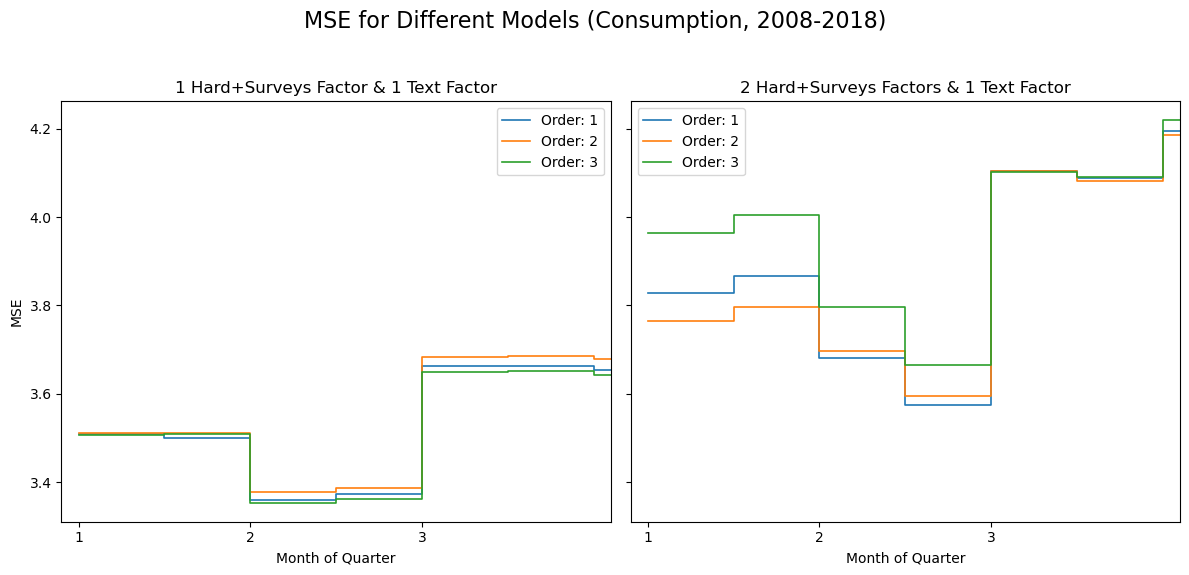

In [2]:
import os
import matplotlib.pyplot as plt
import pandas as pd

vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]
q_var = 'Consumption'
text_type = "topics_uncertainty"
estimation_period = "2007"
num_topics = "200"
source = "all"

# Define a mapping for each vintage to a numeric x-value
x_mapping = {
    "M1-01": 1.0,
    "M1-16": 1.5,
    "M2-01": 2.0,
    "M2-16": 2.5,
    "M3-01": 3.0,
    "M3-16": 3.5,
    "M4-01": 4.0
}

# Construct x values based on the vintages
x_values = [x_mapping[col] for col in vintage_col_names]
# Extend the x array so that the last step extends to the end of the x-axis
x_extended = x_values.copy()
x_extended.append(4.1)  # extend x-axis to 4.1

# Define the directory containing MSE files
mse_dir = f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}"

# Create a figure with 1 row and 2 columns of subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Loop over the number of HardSurveys factors (1 or 2)
for i, num_factors in enumerate(range(1, 3)):
    ax = axs[i]
    # Within each subplot, loop over factor orders 1 to 3
    for order in range(1, 4):
        # Construct file name based on the model's parameters
        factors_str = f"HS_{num_factors}_{order}"
        mse_file_name = f"MSE_{q_var}_{factors_str}.csv"
        mse_file_path = os.path.join(mse_dir, mse_file_name)
        
        # Load the MSE values from file
        mse_df = pd.read_csv(mse_file_path)
        # Construct y values based on the vintages
        y_values = [mse_df[col].iloc[0] for col in vintage_col_names]
        
        # Extend the y-values so the step function holds the last value
        y_extended = y_values.copy()
        y_extended.append(y_values[-1]) # Repeat the last value
        
        # Plot the step function for the current model
        ax.step(x_extended, y_extended, where='post', linewidth=1.2, 
                 label=f"Order: {order}")
        
    # Customize the subplot
    ax.set_xlabel("Month of Quarter")
    # Set ticks only at 1, 2, and 3 to mark the beginning of each month
    ax.set_xticks([1, 2, 3])
    ax.set_xlim(0.9, 4.1)
    ax.set_title(f"{num_factors} Hard+Surveys Factor{'s' if num_factors > 1 else ''} & 1 Text Factor")
    if i == 0:  # Only the leftmost subplot gets the y-axis label
        ax.set_ylabel("MSE")
    ax.legend()

plt.suptitle(f"MSE for Different Models ({q_var}, 2008-2018)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}", exist_ok=True)
base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_2008-2018_{q_var}")
plt.savefig(f"{base_filename}.png", format="png")
plt.savefig(f"{base_filename}.eps", format="eps")

plt.show()

Plot MSE values for all models evaluated over the 2008–2010 and 2011-2018 periods.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


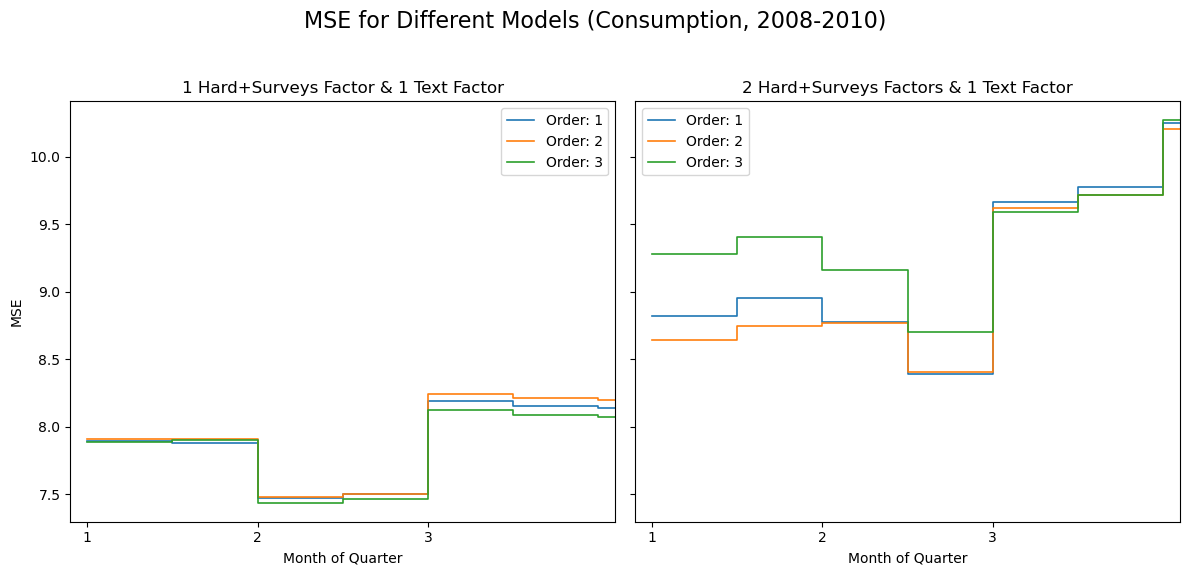

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


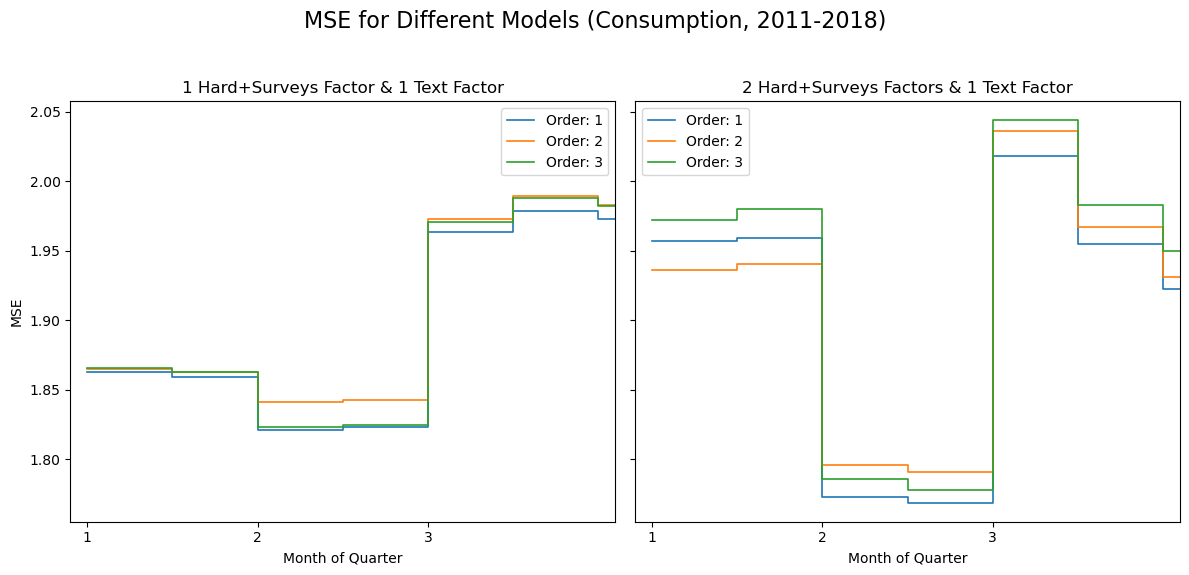

In [3]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def quarter_to_float(q_str):
    """
    Convert a string like 'YYYY-MM'
    into a float: e.g. 2008-03 -> 2008.00, 2008-06 -> 2008.25, etc.
    """
    year = int(q_str[:4])
    month = int(q_str[5:])
    # Map month to fraction of the year
    if month == 3:
        fraction = 0.00
    elif month == 6:
        fraction = 0.25
    elif month == 9:
        fraction = 0.50
    elif month == 12:
        fraction = 0.75
    return year + fraction

# Forecast variable and directories
q_var = 'Consumption'
text_type = "topics_uncertainty"
estimation_period = "2007"
num_topics = "200"
source = "all"
forecasts_dir = f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}"
actual_growth_file = f"../{q_var}_growth_actual.csv"

# Vintage columns
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Load actual growth data and convert 'date' to float
actual_growth = pd.read_csv(actual_growth_file)
actual_growth["date_float"] = actual_growth["date"].apply(quarter_to_float)
actual_growth.sort_values("date_float", inplace=True)

# Define two periods
periods = {
    "2008-2010": lambda df: df["date_float"] < 2011,
    "2011-2018": lambda df: df["date_float"] >= 2011
}

# Define a mapping for each vintage to a numeric x-value
x_mapping = {
    "M1-01": 1.0,
    "M1-16": 1.5,
    "M2-01": 2.0,
    "M2-16": 2.5,
    "M3-01": 3.0,
    "M3-16": 3.5,
    "M4-01": 4.0
}

# Construct x values based on the vintages
x_values = [x_mapping[col] for col in vintage_col_names]
# Extend the x array so that the last step extends to the end of the x-axis
x_extended = x_values.copy()
x_extended.append(4.1)  # extend x-axis to 4.1

# Loop over each period and create a separate figure
for period_label, period_filter in periods.items():
    
    # Create a figure with 1 row and 2 columns of subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
    
    # Loop over the number of HardSurveys factors (1 or 2)
    for i, num_factors in enumerate(range(1, 3)):
        ax = axs[i]
        # Within each subplot, loop over factor orders 1 to 3
        for order in range(1, 4):
            # Construct forecast file name, e.g., "forecasts_Consumption_HS_1_1.csv"
            factors_str = f"HS_{num_factors}_{order}"
            forecast_file_name = f"forecasts_{q_var}_{factors_str}.csv"
            forecast_file_path = os.path.join(forecasts_dir, forecast_file_name)
    
            # Load forecast data 
            forecasts = pd.read_csv(forecast_file_path, index_col=0)
            forecasts.index.name = "date"
            forecasts.reset_index(inplace=True)
            
            # Merge forecasts with actual growth 
            merged = pd.merge(forecasts, actual_growth, on="date", how="inner")
            merged["date_float"] = merged["date"].apply(quarter_to_float)
            merged.sort_values("date_float", inplace=True)
            
            # Filter merged data for the current period
            merged_period = merged[ period_filter(merged) ]
            
            # Calculate MSE for each vintage column over the filtered period
            mse_dict = {}
            for col in vintage_col_names:
                mse = ((merged_period[col] - merged_period["growth"]) ** 2).mean()
                mse_dict[col] = mse
                
            # Construct y values based on the vintages
            y_values = [mse_dict[col] for col in vintage_col_names]
            
            # Extend the y-values so the step function holds the last value
            y_extended = y_values.copy()
            y_extended.append(y_values[-1]) # Repeat the last value
            
            # Plot the step function for the current model (order)
            ax.step(x_extended, y_extended, where='post', linewidth=1.2, 
                    label=f"Order: {order}")
            
        # Customize the subplot
        ax.set_xlabel("Month of Quarter")
        # Set ticks only at 1, 2, and 3 to mark the beginning of each month
        ax.set_xticks([1, 2, 3])
        ax.set_xlim(0.9, 4.1)
        ax.set_title(f"{num_factors} Hard+Surveys Factor{'s' if num_factors > 1 else ''} & 1 Text Factor")
        if i == 0:  # Only the leftmost subplot gets the y-axis label
            ax.set_ylabel("MSE")
        ax.legend()
   
    plt.suptitle(f"MSE for Different Models ({q_var}, {period_label})", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
    os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}", exist_ok=True)
    base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{period_label}_{q_var}")
    plt.savefig(f"{base_filename}.png", format="png")
    plt.savefig(f"{base_filename}.eps", format="eps")

    plt.show()

Plot forecasts vs actual growth values for all models and different time periods (2008-2010, 2008-2018, and 2011-2018).

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


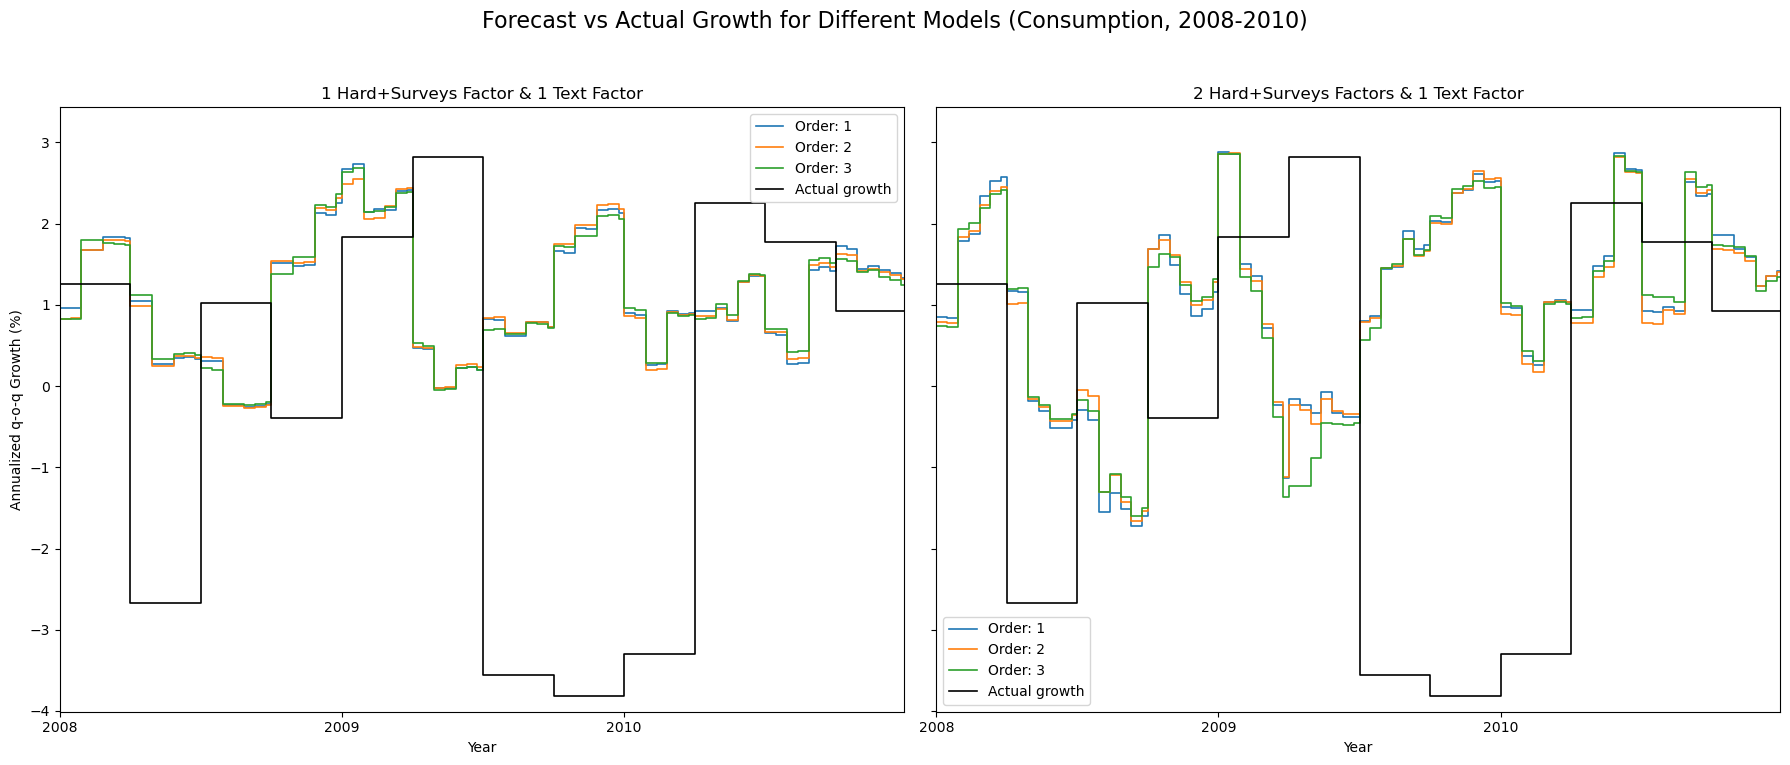

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


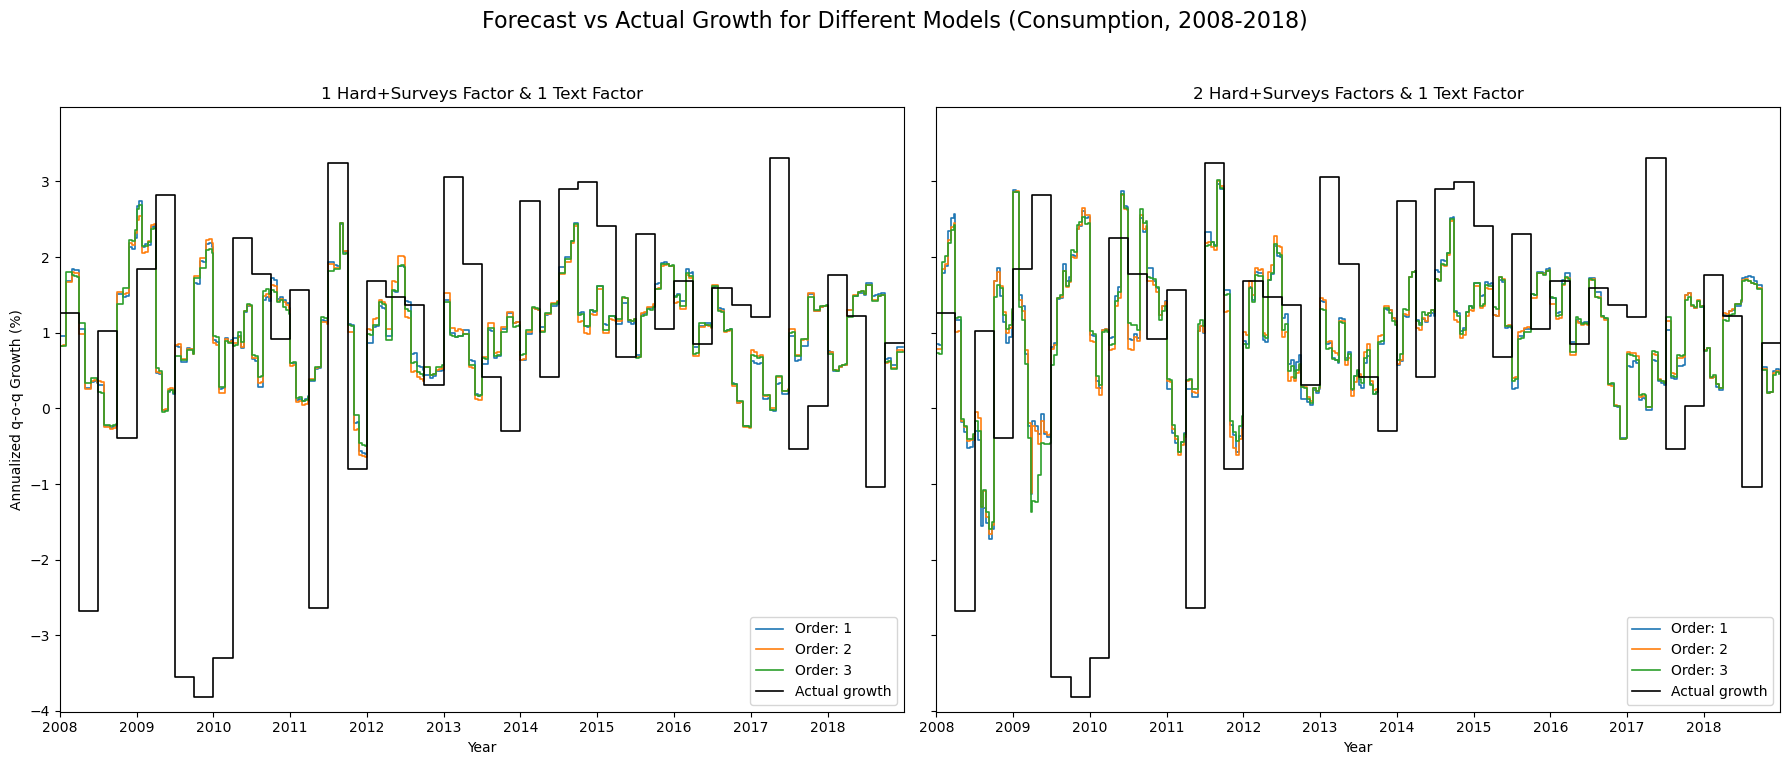

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


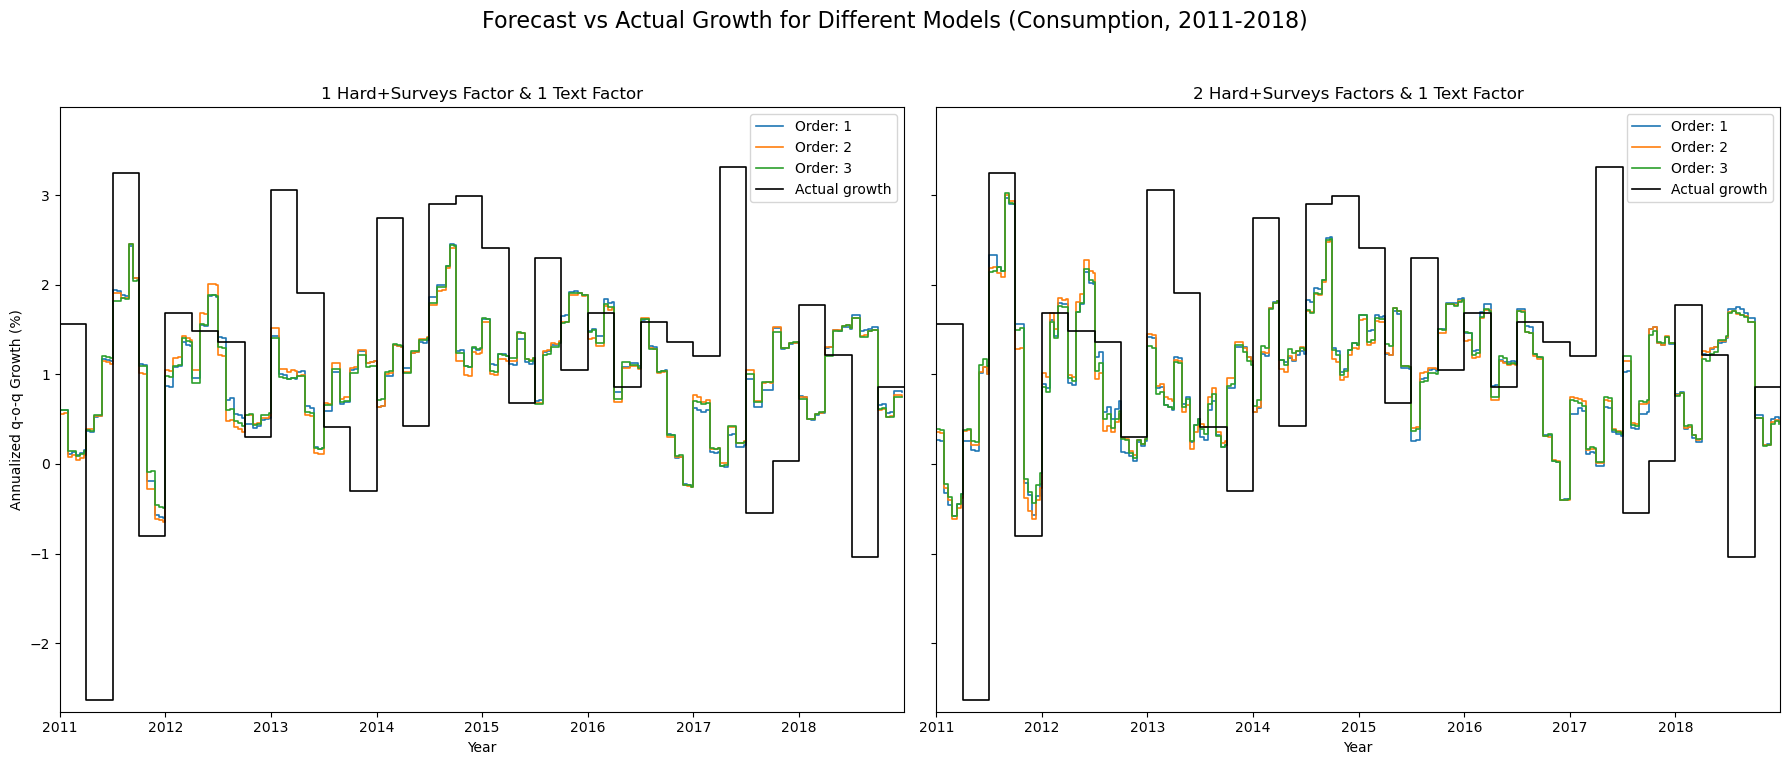

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Convert quarter strings like "2008-03" into a float (e.g. 2008.00 for Q1, 2008.25 for Q2, etc.)
def quarter_to_float(q_str):
    """
    Convert a string like 'YYYY-MM'
    into a float: e.g. 2008-03 -> 2008.00, 2008-06 -> 2008.25, etc.
    """
    year = int(q_str[:4])
    month = int(q_str[5:])
    # Map month to fraction of the year
    if month == 3:
        fraction = 0.00
    elif month == 6:
        fraction = 0.25
    elif month == 9:
        fraction = 0.50
    elif month == 12:
        fraction = 0.75
    return year + fraction

# Forecast variable and directories
q_var = 'Consumption'
text_type = "topics_uncertainty"
estimation_period = "2007"
num_topics = "200"
source = "all"
forecasts_dir = f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}"
actual_growth_file = f"../{q_var}_growth_actual.csv"

# Vintage columns
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Assign 7 small offsets within each quarter, so each quarter has 7 forecast points
offsets = np.linspace(0, 0.23, 7)

# Load actual growth data and convert 'date' to float
actual_growth = pd.read_csv(actual_growth_file)
actual_growth["date_float"] = actual_growth["date"].apply(quarter_to_float)
actual_growth.sort_values("date_float", inplace=True)

# Build x,y arrays for the actual growth
x_act = actual_growth["date_float"].tolist()
y_act = actual_growth["growth"].tolist()

# Define period configurations: x-axis limits and tick positions for each period
period_configs = {
    "2008-2010": {"xlim": (2008, 2010.99), "xticks": list(range(2008, 2011))},
    "2008-2018": {"xlim": (2008, 2018.99), "xticks": list(range(2008, 2019))},
    "2011-2018": {"xlim": (2011, 2018.99), "xticks": list(range(2011, 2019))}
}

# Loop over each period configuration to create and save separate plots
for period_label, config in period_configs.items():
    
    # Extend the actual growth arrays so that the step function continues until the end of the x-axis
    if period_label in ["2008-2018", "2011-2018"]:
        x_act_extended = x_act.copy()
        x_act_extended.append(config["xlim"][1])
        y_act_extended = y_act.copy()
        y_act_extended.append(y_act[-1])
    else:
        x_act_extended = x_act
        y_act_extended = y_act

    # Create a figure with 1 row and 2 columns for the two Hard+Surveys factor counts
    fig, axs = plt.subplots(1, 2, figsize=(18, 8), sharey=True)

    # Loop over the number of HardSurveys factors (1 or 2)
    for i, num_factors in enumerate([1, 2]):
        ax = axs[i]

        # For each HardSurveys factor count, plot forecasts for orders 1, 2, and 3
        for order in range(1, 4):

            # Construct forecast file name, e.g., "forecasts_Consumption_HS_1_1.csv"
            factors_str = f"HS_{num_factors}_{order}"
            forecast_file_name = f"forecasts_{q_var}_{factors_str}.csv"
            forecast_file_path = os.path.join(forecasts_dir, forecast_file_name)

            # Load forecast data 
            forecasts = pd.read_csv(forecast_file_path, index_col=0)
            forecasts.index.name = "date"
            forecasts.reset_index(inplace=True)

            # Merge forecasts with actual growth dates
            merged = pd.merge(forecasts, actual_growth[['date']], on="date", how="inner")
            merged["date_float"] = merged["date"].apply(quarter_to_float)
            merged.sort_values("date_float", inplace=True)

            # Build forecast x and y arrays 
            x_fore = []
            y_fore = []
            for idx, row in merged.iterrows():
                base_x = row["date_float"]
                # For each of the 7 vintage columns, define an x-position and take that forecast value
                for j, col in enumerate(vintage_col_names):
                    x_fore.append(base_x + offsets[j])
                    y_fore.append(row[col])

            # Plot the forecast step curve for the current order
            ax.step(x_fore, y_fore, where='post', linewidth=1.2, label=f"Order: {order}")

        # Plot actual growth as a step plot in each subplot
        ax.step(x_act_extended, y_act_extended, where='post', color='black', linewidth=1.2, label="Actual growth")

        # Customize the subplot
        ax.set_xlabel("Year")
        ax.set_xlim(config["xlim"][0], config["xlim"][1])
        ax.set_xticks(config["xticks"])
        
        # Set y-axis limits based on the data within the period range
        x_min, x_max = config["xlim"]
        def filter_points(x_arr, y_arr, x_min, x_max):
            return [y for x, y in zip(x_arr, y_arr) if x_min <= x <= x_max]

        # Filter y-values
        y_filtered = filter_points(x_fore, y_fore, x_min, x_max)
        y_act_filtered = filter_points(x_act_extended, y_act_extended, x_min, x_max)
        
        # Combine all filtered y-values
        combined_y = y_filtered + y_act_filtered
        ax.set_ylim(1.05 * min(combined_y), 1.2 * max(combined_y))
        
        ax.set_title(f"{num_factors} Hard+Surveys Factor{'s' if num_factors > 1 else ''} & 1 Text Factor")
        if i == 0:
            ax.set_ylabel("Annualized q-o-q Growth (%)")
        ax.legend()
        
    plt.suptitle(f"Forecast vs Actual Growth for Different Models ({q_var}, {period_label})", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
    os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}", exist_ok=True)
    base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_{q_var}", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}_separate_factors_forecast_vs_actual_{period_label}_{q_var}")
    plt.savefig(f"{base_filename}.png", format="png")
    plt.savefig(f"{base_filename}.eps", format="eps")

    plt.show()